# Assignment 3 - Sentiment Analysis
** Dictionary-based sentiment analysis with Python **

Download the following CSV file from Kaggle:
https://www.kaggle.com/therohk/million-headlines

This is a dataset of over a million headlines taken from the Australian news source ABC (Start Date: 2003-02-19 ; End Date: 2020-12-31).

- Calculate the sentiment score for every headline in the data. You can do this using the spaCyTextBlob approach that we covered in class or any other dictionary-based approach in Python.
- Create and save a plot of sentiment over time with a 1-week rolling average
- Create and save a plot of sentiment over time with a 1-month rolling average
- Make sure that you have clear values on the x-axis and that you include the following: a plot title; labels for the x and y axes; and a legend for the plot
- Write a short summary (no more than a paragraph) describing what the two plots show. You should mention the following points: 1) What (if any) are the general trends? 2)
- What (if any) inferences might you draw from them?


HINT: You'll probably want to calculate an average score for each day first, before calculating the rolling averages for weeks and months.


### General instructions

For this assignment, you should upload a standalone .py script which can be executed from the command line or a Jupyter Notebook
Save your script as sentiment.py or sentiment.ipynb
Make sure to include a requirements.txt file and details about where to find the data
You can either upload the scripts here or push to GitHub and include a link - or both!
Your code should be clearly documented in a way that allows others to easily follow the structure of your script and to use them from the command line


### Purpose

This assignment is designed to test that you have a understanding of:

- how to perform dictionary-based sentiment analysis in Python
- how to effectively use pandas and spaCy in a simple NLP workflow
- how to present results visually, working with datetime formats to show trends over time

In [75]:
# Importing all the necessary modules
import os
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from pathlib import Path
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
spacy_text_blob = SpacyTextBlob()
nlp = spacy.load("en_core_web_sm")

In [76]:
# Importing the dataset
df = pd.read_csv(os.path.join("..", "data", "abcnews-date-text.csv"))
df = df.iloc[0:10001, :]

In [77]:
def convert_to_datetime(df, date_col):
    
    # Creating an empty list which is going to contain the dates in date format instead of numerical
    dates = []
    
    # For each index, and each row in df
    for index, row in df.iterrows():
        
        # take the publish_date and convert to string
        date = str(row[date_col])

        # use datetime.date to make the date into datetime, using indices
        date = datetime.date(int(date[0:4]), int(date[4:6]), int(date[6:]))
        
        # append to "dates" list
        dates.append(date)
        
    # overwrite the column "publish_date" with the new dates in datetime format.
    df[date_col] = dates

In [78]:
def calc_sentiment(df, text_col):

    # Calculate polarity for all headlines and add the polarity score to the dataframe
    sentiment_score = []
    for doc in nlp.pipe(df[text_col]):
        score = doc._.sentiment.polarity
        sentiment_score.append(score)

    df["sentiment_score"] = sentiment_score

In [79]:
def calc_daily_avg_sentiment(df, date_col, sentiment_score_col):
    # Get a list of all unique dates in the dataframe
    unique_dates = list(pd.unique(df[date_col]))

    # Create a new dataframe, with a row for each unique date. Also calculate the mean polarity score for each unique date
    df_dates = pd.DataFrame()
    daily_mean_polarity_score = []

    # For each unique date, get the mean of all sentiment scores, and store it in "daily_mean_polarity_score"
    for unique_date in unique_dates:
        df_for_date_n = df.loc[df[date_col] == unique_date]
        mean_for_date_n = np.mean(df_for_date_n[sentiment_score_col])
        df_dates["date"] = unique_dates
        daily_mean_polarity_score.append(mean_for_date_n)

    # Create a new column with the daily mean polarity scores
    df_dates["daily_mean_polarity_score"] = daily_mean_polarity_score

    # Calculate smoothed mean scores for each date, using a window of 7 days
    daily_polarity_score_weekly_smooth = pd.Series(df_dates["daily_mean_polarity_score"]).rolling(7).mean()

    # Calculate smoothed mean scores for each date, using a window of 30 days  
    daily_polarity_score_monthly_smooth = pd.Series(df_dates["daily_mean_polarity_score"]).rolling(30).mean()

    # Add the smoothed data to the df_dates
    df_dates["daily_polarity_score_weekly_smooth"] = daily_polarity_score_weekly_smooth
    df_dates["daily_polarity_score_monthly_smooth"] = daily_polarity_score_monthly_smooth

    return df_dates

In [80]:
def plot_sentiment(df, start_date, col_no_smooth, col_smooth_7_days, col_smooth_30_days, save = False):
    
    # Adding a figure which is large enough for multiple subplots
    fig = plt.figure(figsize = (24.0, 10.0))

    # Adding subplots
    axes_1 = fig.add_subplot(2,3,2) # 2 rows, 3 columns, 2nd position
    axes_2 = fig.add_subplot(2,3,4) # 2 rows, 3 columns, 4th position
    axes_3 = fig.add_subplot(2,3,5) # 2 rows, 3 columns, 5th position
    axes_4 = fig.add_subplot(2,3,6) # 2 rows, 3 columns, 6th position

    # Defining axes_1 plot
    axes_1.plot(df[col_no_smooth], "b", linewidth = 2)
    axes_1.plot(df[col_smooth_7_days], "g", linewidth = 2)
    axes_1.plot(df[col_smooth_30_days], "r", linewidth = 2)
    axes_1.set_title("Daily mean sentiment score of headlines \n and smoothing differences")
    axes_1.set_xlabel(f"Days after {start_date}")
    axes_1.set_ylabel("Mean sentiment scores")
    
    # Defining axes_2 plot
    axes_2.set_title("Daily mean sentiment score of headlines")
    axes_2.set_ylabel("Mean sentiment score")
    axes_2.set_xlabel(f"Days after {start_date}")
    axes_2.plot(df[col_no_smooth], "b", linewidth = 2)
    axes_2.legend("Daily", loc="upper left")

    # Defining axes_3 plot
    axes_3.set_title("Daily mean sentiment score of headlines \n (smoothed, 7-day window)")
    axes_3.set_ylabel("Mean sentiment score (smoothed, 7-days)")
    axes_3.set_xlabel(f"Days after {start_date}")
    axes_3.plot(df[col_smooth_7_days], "g", linewidth = 2)
    axes_3.legend("Weekly average around the date", loc="upper left")

    # Defining axes_4 plot
    axes_4.set_title("Daily mean sentiment score of headlines \n (smoothed, 30-day window")
    axes_4.set_ylabel("Mean sentiment score (smoothed, 30-days)")
    axes_4.set_xlabel(f"Days after {start_date}")
    axes_4.plot(df[col_smooth_30_days], "r", linewidth = 2)
    axes_4.legend("Monthly average around the date", loc="upper left")

    # So that the font doesn't overlap
    plt.tight_layout()
    
    # To save
    if save == True:
        plt.savefig("polarity_plot.png")

    # To show the plot
    plt.show(fig)


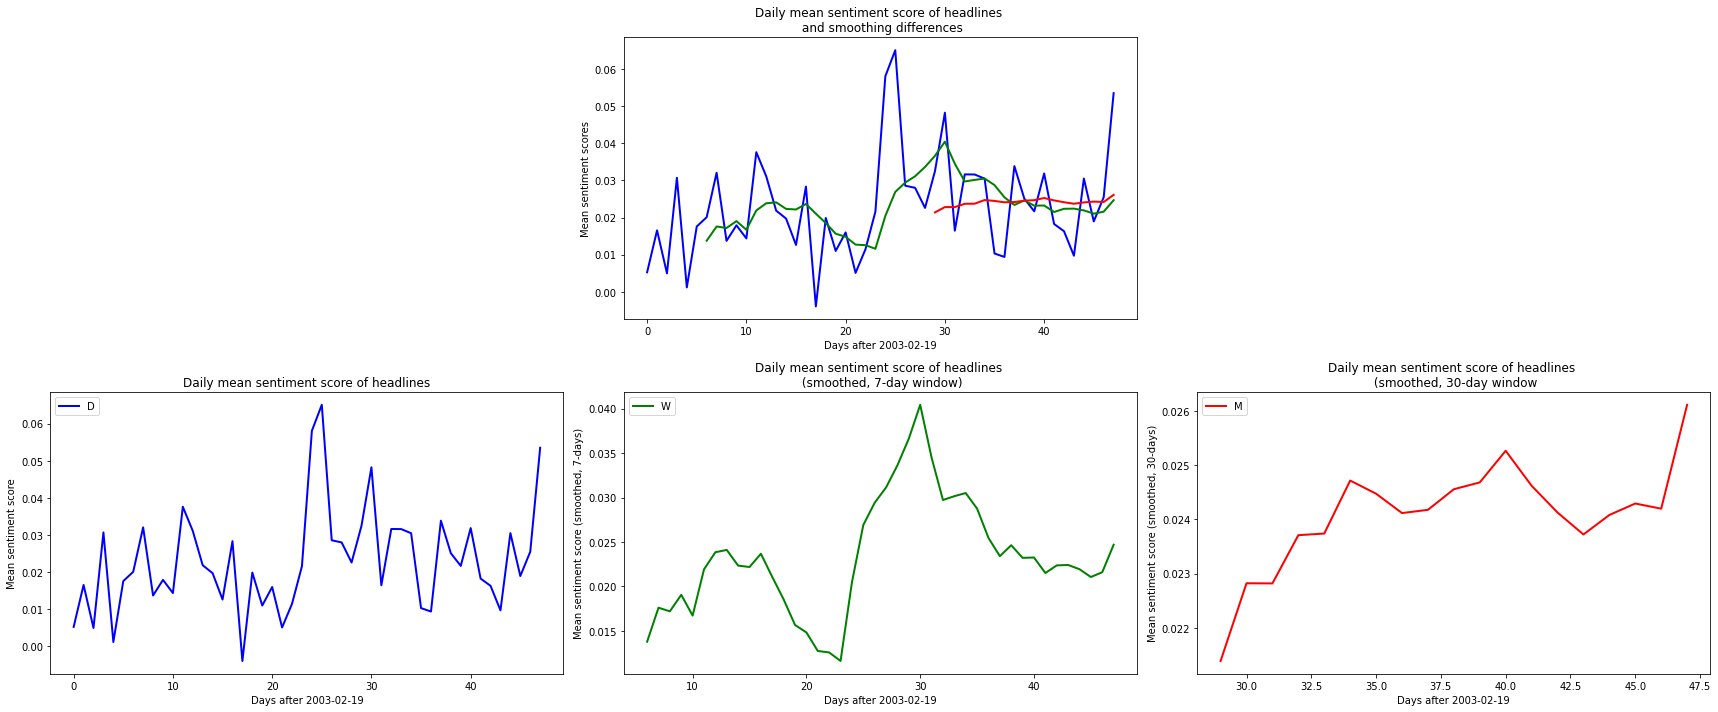

In [81]:
convert_to_datetime(df, "publish_date")
calc_sentiment(df, "headline_text")
df_dates = calc_daily_avg_sentiment(df, "publish_date", "sentiment_score")
plot_sentiment(df = df_dates, start_date = "2003-02-19", col_no_smooth = "daily_mean_polarity_score", col_smooth_7_days = "daily_polarity_score_weekly_smooth", col_smooth_30_days = "daily_polarity_score_monthly_smooth", save = True)